## 2D-CNN for Malayalam

In [1]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# Setting parameters
test_dim = 431  # Dimension to pad/truncate MFCC features
batch_size = 32  # Adjust based on available memory
nb_filter = 64  # Number of filters in Conv2D layers
filter_length_1 = (3, 3)  # Length of the first filter
filter_length_2 = (3, 3)  # Length of the second filter
nb_epoch = 20  # Number of epochs for training
hidden_dims = 250  # Number of hidden units in Dense layer 
nb_classes = 4  # Number of classes

# Function to load audio files and extract MFCC features
def load_data(data_dir):
    X = []
    y = []
    class_labels = {}
    class_index = 0

    for subdir, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.wav'):  # Assuming audio files are in .wav format
                file_path = os.path.join(subdir, file)
                label = os.path.basename(subdir)
                if label not in class_labels:
                    class_labels[label] = class_index
                    class_index += 1
                
                # Load audio file and extract MFCC features
                audio, sr = librosa.load(file_path, sr=None)
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=39, n_fft=480, hop_length=512)
                if mfcc.shape[1] < test_dim:
                    mfcc = np.pad(mfcc, ((0, 0), (0, test_dim - mfcc.shape[1])), mode='constant')
                else:
                    mfcc = mfcc[:, :test_dim]
                X.append(mfcc.T)
                y.append(class_labels[label])
    
    return np.array(X), np.array(y), class_labels

# Load data
data_dir = '/dist_home/jairam/Malayalam/'
print('Loading data...')
X, y, class_labels = load_data(data_dir)

# Ensure X has the correct shape for Conv2D input (batch_size, height, width, channels)
X = np.expand_dims(X, -1)  # Add a new axis to match (batch_size, height, width, channels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')
nb_classes = len(class_labels)  # Update number of classes based on data
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

# Build the 2DCNN model
print('Build model...')
model = Sequential()

# Add convolutional layers
model.add(Conv2D(filters=nb_filter,
                 kernel_size=filter_length_1,
                 input_shape=(test_dim, 39, 1),
                 activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=nb_filter,
                 kernel_size=filter_length_2,
                 padding='same',
                 activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=nb_filter,
                 kernel_size=filter_length_2,
                 padding='same',
                 activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the conv layer
model.add(Flatten())

# Add dropout for regularization
model.add(Dropout(0.25))

# Add output layer with softmax activation for multiclass classification
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train, Y_train, batch_size=batch_size,
                    epochs=nb_epoch, verbose=1,
                    validation_data=(X_test, Y_test))

# Evaluate the model
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Generate classification report
y_preds = model.predict(X_test)
y_pred_classes = np.argmax(y_preds, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)
print(classification_report(y_true_classes, y_pred_classes, target_names=list(class_labels.keys())))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)


2025-03-29 18:17:37.166013: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-29 18:17:37.177821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-29 18:17:37.190845: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-29 18:17:37.194706: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-29 18:17:37.205963: I tensorflow/core/platform/cpu_feature_guar

Loading data...
6455 train sequences
1614 test sequences
Build model...


/dist_home/common-apps/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-29 18:18:28.518137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:41:00.0, compute capability: 8.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 429, 37, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 429, 37, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 429, 37, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 429, 37, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 214, 18, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 214, 18, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 214, 18, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 107, 9, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 61632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       246,532 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,796 (1.23 MB)

 Trainable params: 321,412 (1.23 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20


I0000 00:00:1743252511.719173 1323131 service.cc:146] XLA service 0x75d8c000bdc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743252511.719208 1323131 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-03-29 18:18:31.753860: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-29 18:18:31.871172: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 22/202 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3649 - loss: 33.5328

I0000 00:00:1743252515.240895 1323131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


202/202 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5122 - loss: 14.8568 - val_accuracy: 0.7218 - val_loss: 2.9093
Epoch 2/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7316 - loss: 3.4260 - val_accuracy: 0.6654 - val_loss: 5.0960
Epoch 3/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8167 - loss: 2.0073 - val_accuracy: 0.7559 - val_loss: 3.1589
Epoch 4/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8731 - loss: 1.2964 - val_accuracy: 0.6574 - val_loss: 5.0155
Epoch 5/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9053 - loss: 0.9372 - val_accuracy: 0.7026 - val_loss: 5.4729
Epoch 6/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9199 - loss: 0.7556 - val_accuracy: 0.7392 - val_loss: 5.1797
Epoch 7/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9445 - loss: 0.4681 - val_accuracy: 0.7577 - val_loss: 4.3898
Epoch 8/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9535 - loss: 0.4851 - val_accuracy: 0.7162 - v

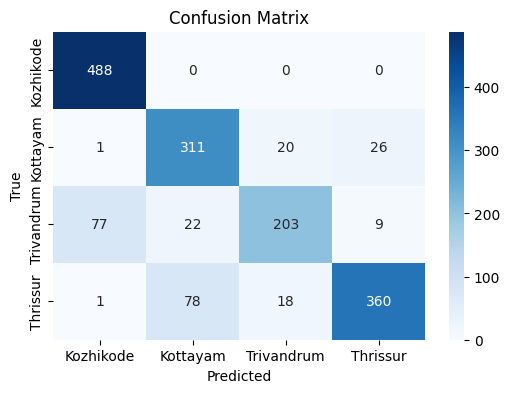

In [2]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_labels.keys()), yticklabels=list(class_labels.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Tamil

In [4]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# Setting parameters
test_dim = 431  # Dimension to pad/truncate MFCC features
batch_size = 32  # Adjust based on available memory
nb_filter = 64  # Number of filters in Conv2D layers
filter_length_1 = (3, 3)  # Length of the first filter
filter_length_2 = (3, 3)  # Length of the second filter
nb_epoch = 20  # Number of epochs for training
hidden_dims = 250  # Number of hidden units in Dense layer 
nb_classes = 4  # Number of classes

# Function to load audio files and extract MFCC features
def load_data(data_dir):
    X = []
    y = []
    class_labels = {}
    class_index = 0

    for subdir, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.wav'):  # Assuming audio files are in .wav format
                file_path = os.path.join(subdir, file)
                label = os.path.basename(subdir)
                if label not in class_labels:
                    class_labels[label] = class_index
                    class_index += 1
                
                # Load audio file and extract MFCC features
                audio, sr = librosa.load(file_path, sr=None)
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=39, n_fft=480, hop_length=512)
                if mfcc.shape[1] < test_dim:
                    mfcc = np.pad(mfcc, ((0, 0), (0, test_dim - mfcc.shape[1])), mode='constant')
                else:
                    mfcc = mfcc[:, :test_dim]
                X.append(mfcc.T)
                y.append(class_labels[label])
    
    return np.array(X), np.array(y), class_labels

# Load data
data_dir = '/dist_home/jairam/Tamil/'
print('Loading data...')
X, y, class_labels = load_data(data_dir)

# Ensure X has the correct shape for Conv2D input (batch_size, height, width, channels)
X = np.expand_dims(X, -1)  # Add a new axis to match (batch_size, height, width, channels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')
nb_classes = len(class_labels)  # Update number of classes based on data
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

# Build the 2DCNN model
print('Build model...')
model = Sequential()

# Add convolutional layers
model.add(Conv2D(filters=nb_filter,
                 kernel_size=filter_length_1,
                 input_shape=(test_dim, 39, 1),
                 activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=nb_filter,
                 kernel_size=filter_length_2,
                 padding='same',
                 activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=nb_filter,
                 kernel_size=filter_length_2,
                 padding='same',
                 activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the conv layer
model.add(Flatten())

# Add dropout for regularization
model.add(Dropout(0.25))

# Add output layer with softmax activation for multiclass classification
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train, Y_train, batch_size=batch_size,
                    epochs=nb_epoch, verbose=1,
                    validation_data=(X_test, Y_test))

# Evaluate the model
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Generate classification report
y_preds = model.predict(X_test)
y_pred_classes = np.argmax(y_preds, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)
print(classification_report(y_true_classes, y_pred_classes, target_names=list(class_labels.keys())))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)


Loading data...
5948 train sequences
1487 test sequences
Build model...


/dist_home/common-apps/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 429, 37, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 429, 37, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 429, 37, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 429, 37, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 214, 18, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 214, 18, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 214, 18, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 107, 9, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 61632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │       246,532 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,796 (1.23 MB)

 Trainable params: 321,412 (1.23 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.6171 - loss: 11.0312 - val_accuracy: 0.5091 - val_loss: 22.2465
Epoch 2/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7992 - loss: 2.8284 - val_accuracy: 0.7102 - val_loss: 3.6527
Epoch 3/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8770 - loss: 1.2259 - val_accuracy: 0.7949 - val_loss: 1.8112
Epoch 4/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9102 - loss: 0.8757 - val_accuracy: 0.7451 - val_loss: 3.4136
Epoch 5/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9249 - loss: 0.7827 - val_accuracy: 0.8393 - val_loss: 1.6869
Epoch 6/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9440 - loss: 0.4873 - val_accuracy: 0.8500 - val_loss: 2.4660
Epoch 7/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9588 - loss: 0.3542 - val_accuracy: 0.8487 - val_loss: 1.7483
Epoch 8/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9664 - loss: 0.2935 - val_accuracy:

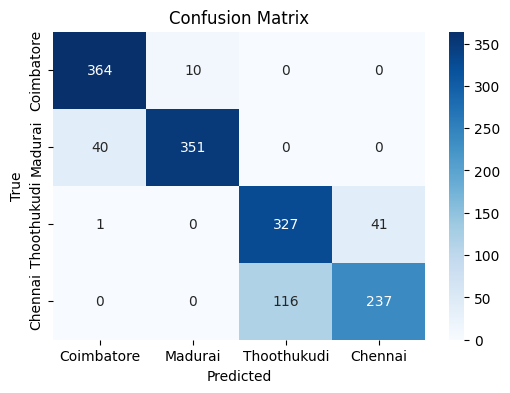

In [5]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_labels.keys()), yticklabels=list(class_labels.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Kannada

In [7]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# Setting parameters
test_dim = 431  # Dimension to pad/truncate MFCC features
batch_size = 32  # Adjust based on available memory
nb_filter = 64  # Number of filters in Conv2D layers
filter_length_1 = (3, 3)  # Length of the first filter
filter_length_2 = (3, 3)  # Length of the second filter
nb_epoch = 20  # Number of epochs for training
hidden_dims = 250  # Number of hidden units in Dense layer 
nb_classes = 4  # Number of classes

# Function to load audio files and extract MFCC features
def load_data(data_dir):
    X = []
    y = []
    class_labels = {}
    class_index = 0

    for subdir, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.wav'):  # Assuming audio files are in .wav format
                file_path = os.path.join(subdir, file)
                label = os.path.basename(subdir)
                if label not in class_labels:
                    class_labels[label] = class_index
                    class_index += 1
                
                # Load audio file and extract MFCC features
                audio, sr = librosa.load(file_path, sr=None)
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=39, n_fft=480, hop_length=512)
                if mfcc.shape[1] < test_dim:
                    mfcc = np.pad(mfcc, ((0, 0), (0, test_dim - mfcc.shape[1])), mode='constant')
                else:
                    mfcc = mfcc[:, :test_dim]
                X.append(mfcc.T)
                y.append(class_labels[label])
    
    return np.array(X), np.array(y), class_labels

# Load data
data_dir = '/dist_home/jairam/Kannada/'
print('Loading data...')
X, y, class_labels = load_data(data_dir)

# Ensure X has the correct shape for Conv2D input (batch_size, height, width, channels)
X = np.expand_dims(X, -1)  # Add a new axis to match (batch_size, height, width, channels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')
nb_classes = len(class_labels)  # Update number of classes based on data
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

# Build the 2DCNN model
print('Build model...')
model = Sequential()

# Add convolutional layers
model.add(Conv2D(filters=nb_filter,
                 kernel_size=filter_length_1,
                 input_shape=(test_dim, 39, 1),
                 activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=nb_filter,
                 kernel_size=filter_length_2,
                 padding='same',
                 activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=nb_filter,
                 kernel_size=filter_length_2,
                 padding='same',
                 activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the conv layer
model.add(Flatten())

# Add dropout for regularization
model.add(Dropout(0.25))

# Add output layer with softmax activation for multiclass classification
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train, Y_train, batch_size=batch_size,
                    epochs=nb_epoch, verbose=1,
                    validation_data=(X_test, Y_test))

# Evaluate the model
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Generate classification report
y_preds = model.predict(X_test)
y_pred_classes = np.argmax(y_preds, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)
print(classification_report(y_true_classes, y_pred_classes, target_names=list(class_labels.keys())))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)


Loading data...
6456 train sequences
1615 test sequences
Build model...


/dist_home/common-apps/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 429, 37, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 429, 37, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 429, 37, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 429, 37, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 214, 18, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 214, 18, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 214, 18, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 107, 9, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 61632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 61632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │       246,532 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,796 (1.23 MB)

 Trainable params: 321,412 (1.23 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.3554 - loss: 18.5608 - val_accuracy: 0.4433 - val_loss: 8.7852
Epoch 2/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6093 - loss: 4.9549 - val_accuracy: 0.5728 - val_loss: 6.2165
Epoch 3/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7499 - loss: 2.5488 - val_accuracy: 0.6551 - val_loss: 5.1061
Epoch 4/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8306 - loss: 1.5609 - val_accuracy: 0.6217 - val_loss: 6.4834
Epoch 5/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8621 - loss: 1.1689 - val_accuracy: 0.7424 - val_loss: 3.6936
Epoch 6/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9123 - loss: 0.7282 - val_accuracy: 0.6861 - val_loss: 5.3767
Epoch 7/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9313 - loss: 0.6673 - val_accuracy: 0.6471 - val_loss: 6.2831
Epoch 8/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9422 - loss: 0.4688 - val_accuracy: 

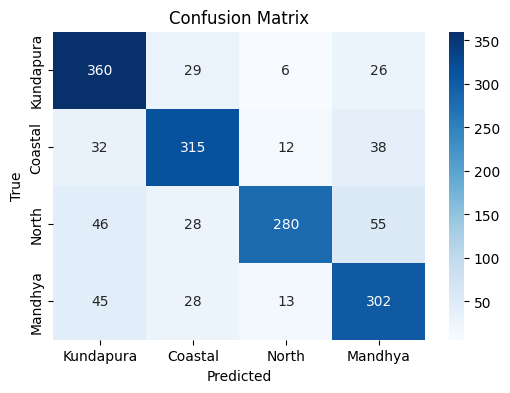

In [8]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_labels.keys()), yticklabels=list(class_labels.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()